# Advanced Lane Finding Project

### goals 
   - Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
   - Apply a distortion correction to raw images.
   - Use color transforms, gradients, etc., to create a thresholded binary image.
   - Apply a perspective transform to rectify binary image ("birds-eye view").
   - Detect lane pixels and fit to find the lane boundary.
   - Determine the curvature of the lane and vehicle position with respect to center.
   - Warp the detected lane boundaries back onto the original image.
   - Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Importing packages

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Debug Functiion

 - Below Function is created Only for debuging purpose
  1. SideBySide
  2. Visulization
     


In [2]:
def SideBySide(img1,img2):
    fig, axs = plt.subplots(1, 2, figsize=(24, 100))
    
    count = 0
    for ax in axs:
        if count == 0:
            ax.imshow(img1)
            count+=1
        else:
            ax.imshow(img2)
            count=0

In [3]:
def Visulization(out_black_img,leftx,lefty,rightx,righty,left_fitx,right_fitx,ploty):
    out_black_img[lefty, leftx] = [255, 0, 0]
    out_black_img[righty, rightx] = [0, 255, 0]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='orange')
    plt.plot(right_fitx, ploty, color='orange')
    
    return out_black_img

### Thresholding 
   - Fn - AbsSobelThresold : Applying Sobel
   - Fn - MeanSobelThersold : Magnitude of gradiant
   - Fn - ColorThresold : Color Thresholding 
   - Fn - Thresold : Mixed of all threshold 

In [4]:
def MeanSobelThersold(img,threshold=(0,255),sobel_kernel=3):
    
    # convert image from RGB to Gray
    gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)                                         
    
    # Using SobelX and SobelY calculate the meanSobel
    sobelx = cv2.Sobel(gray_img,cv2.CV_64F,1,0,ksize=sobel_kernel)                          
    sobely = cv2.Sobel(gray_img,cv2.CV_64F,1,0,ksize=sobel_kernel)
    abs_img = np.sqrt(sobelx**2 + sobely**2)  
    scaler_img = np.uint8(255*(abs_img/np.max(abs_img)))
    
    # Create Grad_Binary
    grad_binary = np.zeros_like(abs_img)
    grad_binary[(scaler_img > threshold[0]) & (scaler_img < threshold[1])] = 1
    return grad_binary

In [5]:
def AbsSobelThresold(img,axis,threshold=(0,255),sobel_kernel=3):
    
    # convert image from RGB to Gray
    gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Use SobelX or SobelY 
    if axis == 'X':
        sobel_img = cv2.Sobel(gray_img,cv2.CV_64F,1,0,ksize=sobel_kernel)
    if axis == 'Y':
        sobel_img = cv2.Sobel(gray_img,cv2.CV_64F,0,1,ksize=sobel_kernel)
    
    abs_img = np.absolute(sobel_img)
    scaler_img = np.uint8(255*(abs_img/(np.max(abs_img))))
    
    # Create Grad_Binary
    grad_binary = np.zeros_like(abs_img)
    grad_binary[(scaler_img > threshold[0]) & (scaler_img < threshold[1])] = 1
    return grad_binary



In [6]:
def DirThreshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # convert image from RGB to Gray
    gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask

In [7]:
def ColorThresold(img,threshold=(0,255)):
    
    # convert image from RGB to HLs Colorspace
    hls_img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    
    # Extracting S_chennal
    s_chennel = hls_img[:,:,2]
    
    # Appling Thresholding on S_Chennel of HLS
    s_binary = np.zeros_like(s_chennel)
    s_binary[(s_chennel > 50) & (s_chennel <= 255)] = 1  #150 255
    
    # Extracting R_chennel
    r_chennel = img[:,:,0]
    
    # Appling Thresholding on R_Chennel of RGB
    r_binary = np.zeros_like(r_chennel)
    r_binary[(r_chennel > 150) & (r_chennel <= 255)] = 1
    
    # Extracting g_chennel
    g_chennel = img[:,:,1]
    
    # Appling Thresholding on G_Chennel of RGB
    g_binary = np.zeros_like(r_chennel)
    g_binary[(g_chennel > 150) & (g_chennel <= 255)] = 1
    
    '''
    luv_image = cv2.cvtColor(img,cv2.COLOR_RGB2LUV)
    v_chennel = luv_image[:,:,2]
    v_binary = np.zeros_like(v_chennel)
    v_binary[(v_chennel > 150) & (v_chennel < 255)] = 1
    '''
    l_chennel = hls_img[:,:,1]
    
    # Appling Thresholding on S_Chennel of HLS
    l_binary = np.zeros_like(l_chennel)
    l_binary[(l_chennel > 50) & (l_chennel <= 255)] = 1
    
    # Mix Both Color Thresold and return Mixed color threshold
    mixedColor = np.zeros_like(s_binary)
    mixedColor[(r_binary == 1) & (s_binary == 1)] = 1
    
    return mixedColor  

In [8]:
# use All Threshold and combine all in one 
def Thresold(img):
    absSobel = AbsSobelThresold(img,"X",(50,150),3)
    meanSobel = MeanSobelThersold(img,(30,200),3)
    dirSobel = DirThreshold(img,3,(np.pi/8, np.pi/2))
    colorThrsold = ColorThresold(img,(230,255)) 
    combined = np.zeros_like(absSobel)
    
    #combined[((absSobel == 1)) | (colorThrsold == 1) ] = 1
    combined[((absSobel == 1)) | (colorThrsold == 1) ] = 1
    #plt.imshow(absSobel)
    #plt.show()
    #SideBySide(img,combined)
    return combined

### Perspective Transformation 
   - Fn - PerspectiveT 
       - A perspective transform maps the points in a given image to different, desired, image points with a new perspective. The perspective transform you’ll be most interested in is a bird’s-eye view transform that let’s us view a lane from above; this will be useful for calculating the lane curvature later on. Aside from creating a bird’s eye view representation of an image, a perspective transform can also be used for all kinds of different view points.

In [9]:
def PerspectiveT(img):
    ImgSize = (img.shape[1], img.shape[0])                                 # calculate hight and width of image

    src = np.float32(                                                      # ROI Points (Src Points)
        [[570, 470],
         [200, 720],
         [1110, 720],           
         [722, 470]])
    
    dst = np.float32(                                                      # Points for perspective Transform (Des Point)
        [[320, 0],
        [320, 720],
        [960, 720],
        [960, 0]])

    ######     Testing Code Start   ######
    
    a = [200,720]                                                             # To Display the ROI on Image
    b = [1180,720]
    c = [550,470] 
    d = [770,470]
    pts = np.array([a,b,d,c])
    
    blackimg = np.zeros_like(img)
    
    mask=cv2.drawContours(blackimg,[pts],0,(255,255,255),-1)
    new_test_img = cv2.bitwise_and(img,mask)
    
   ######     Testing Code End    ######
    
    m = cv2.getPerspectiveTransform(src, dst)                                        # Perspective Transformation 
    warped = cv2.warpPerspective(img, m, ImgSize, flags=cv2.INTER_LINEAR)            # Warp Image based on m
    
    M_inv= cv2.getPerspectiveTransform(dst, src)                                     # will be needed at the end to inverse again
    return warped,M_inv,new_test_img                                                 # here new_test_img is only for debuging


### Sliding Window

 - Fn - SlidingWindow, fitPoly
  - used for Sliding Windows and Fit a Polynomial
  - it will find ind the Histogram 
  - se the two highest peaks from our histogram as a starting point for determining where the lane lines are, and then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go.

In [10]:
def SlidingWindow(binary_warped):

    #histogram = np.sum(2*binary_warped[binary_warped.shape[0]//3:,:], axis=0)      # Find the Histogram of bottom image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)      # Find the Histogram of bottom image
    #plt.plot(histogram)
    #plt.show()
    # To Display Output
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255             
    
    # base left and right
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HyperParameter
    nwindow = 10
    minpix = 100
    margin = 70
    height = np.int(binary_warped.shape[0]//nwindow)
    
    # NonZero in X & Y from Binary Image
    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    left_lane_inds = []
    right_lane_inds = []
    
    # Rotate the loop for nwindow time 
    for window in range(nwindow):
        
        # calculate the Y points for rectangle
        win_y_low = binary_warped.shape[0] - (window+1)*height
        win_y_high = binary_warped.shape[0] - (window)*height
        
        # Calculate X points for rectangle
        win_leftx_low = leftx_current - margin
        win_leftx_high = leftx_current + margin                              
        win_rightx_low = rightx_current - margin
        win_rightx_high = rightx_current + margin
        
        # Draw Ractancgle
        cv2.rectangle(out_img,(win_leftx_low,win_y_low),
        (win_leftx_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_rightx_low,win_y_low),
        (win_rightx_high,win_y_high),(255,0,0), 5) 
    
        # Find out the nonzero points in ractangle box window
        good_leftx_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_leftx_low) &  (nonzerox < win_leftx_high)).nonzero()[0] 
        good_rightx_inds = ((nonzerox >= win_rightx_low) & (nonzerox < win_rightx_high)
                          & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        
        # append this point in relevent side line
        left_lane_inds.append(good_leftx_inds)
        right_lane_inds.append(good_rightx_inds)
        
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_leftx_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_leftx_inds]))
        if len(good_rightx_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_rightx_inds]))
            
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except TypeError:
        pass
    
    # find out all nonzero points in lane_inds
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # fit the polynomial
    left_fit_coef,right_fit_coef,leftx_fit,rightx_fit,ploty = fitPoly(binary_warped,leftx,lefty,rightx,righty)
    visulize_img = None
    #visulize_img = Visulization(out_img,leftx,lefty,rightx,righty,leftx_fit,rightx_fit,ploty)
    
    return visulize_img,left_fit_coef,right_fit_coef,left_lane_inds,right_lane_inds,ploty
    

In [11]:
def fitPoly(binary_warped,leftx,lefty,rightx,righty):
    
    img_shape = (binary_warped.shape[1],binary_warped.shape[0])
    
    # find out the coef 
    left_fit_coef = np.polyfit(lefty,leftx,2)
    right_fit_coef = np.polyfit(righty,rightx,2)
    
    
    ploty = np.linspace(0,img_shape[1]-1,img_shape[1])
    
    # find out the leftx and rightx 
    leftx_fit = left_fit_coef[0]*ploty**2 + left_fit_coef[1]*ploty + left_fit_coef[2]
    rightx_fit = right_fit_coef[0]*ploty**2 + right_fit_coef[1]*ploty + right_fit_coef[2]
    
    return left_fit_coef,right_fit_coef,leftx_fit,rightx_fit,ploty
    

### Skiping the sliding windows step 
   - Fn -  NearSearch, DrawNearArea
    - it will use the previous polynomial to skip the sliding window
    - search in a margin around the previous lane line position
    - This is equivalent to using a customized region of interest for each frame of video

In [12]:
def NearSearch(binary_warped,left_fit_coef,right_fit_coef,ploty):
    margin = 70
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    nonzero = binary_warped.nonzero()
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]
    
    #customized region of interest for each frame
    left_lane_inds = ((nonzerox > (left_fit_coef[0]*(nonzeroy**2) + left_fit_coef[1]*(nonzeroy) + left_fit_coef[2] - margin)) &
                     (nonzerox < (left_fit_coef[0]*(nonzeroy**2) + left_fit_coef[1]*(nonzeroy) + left_fit_coef[2] + margin)))
                      
    right_lane_inds = ((nonzerox > (right_fit_coef[0]*(nonzeroy**2) + right_fit_coef[1]*(nonzeroy) + right_fit_coef[2] - margin)) &
                     (nonzerox < (right_fit_coef[0]*(nonzeroy**2) + right_fit_coef[1]*(nonzeroy) + right_fit_coef[2] + margin)))
                      
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
     
    left_fit_coef,right_fit_coef,leftx_fit,rightx_fit,ploty = fitPoly(binary_warped,leftx,lefty,rightx,righty)
    result = DrawNearArea(out_img,margin,nonzerox,nonzeroy,left_lane_inds,right_lane_inds,leftx_fit,rightx_fit,ploty)
    #out_black_img = Visulization(out_img,leftx,lefty,rightx,righty,leftx_fit,rightx_fit,ploty)
    return result,leftx_fit,rightx_fit

In [13]:
def DrawNearArea(out_img,margin,nonzerox,nonzeroy,left_lane_inds,right_lane_inds,left_fitx,right_fitx,ploty):
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image

    
    return result


### Camera Calibration
 -  Fn - CalibrateCamera 
  - This function is used to calibrate our camera  using chessboard images

In [14]:
def CalibrateCamera():
    nX = 9
    nY = 6
    
    objPoints = []                                       # obj_points = to store the objectpoints ex:
    imgPoints = []                                       # img_points = to store the imagepoints ex:
    
    objp = np.zeros((nX*nY,3), np.float32)               # create nX*nY size matrix having 0
    objp[:,:2] = np.mgrid[0:nX,0:nY].T.reshape(-1,2)     #  (0,0,0),(1,0,0),(2,0,0),...,(9,6,0)
    
    
    # from chessboard Images calibrate the camera 
    for calibImgName in os.listdir('./camera_cal'):
        calibImg = cv2.imread(os.path.join('./camera_cal',calibImgName))
        gray_calibImg = cv2.cvtColor(calibImg,cv2.COLOR_BGR2GRAY)
        
        # find chessBoard Corners
        ret,corners = cv2.findChessboardCorners(gray_calibImg,(nX,nY),None)
        
        if ret == True:
            objPoints.append(objp)
            imgPoints.append(corners)
            calibImg = cv2.drawChessboardCorners(calibImg,(nX,nY),corners,ret)
    
    
    ret,dist,mtx,rvecs,tvecs = cv2.calibrateCamera(objPoints,imgPoints,(calibImg.shape[1],calibImg.shape[0]),None,None)
    
    return dist,mtx

### Undistortion
 -  Fn - UndistortImg 
  - This function is used to undistort Images.
  - Image distortion occurs when a camera looks at 3D objects in the real world and transforms them into a 2D image; this transformation isn’t perfect. Distortion actually changes what the shape and size of these 3D objects appear to be. So, the first step in analyzing camera images, is to undo this distortion so that you can get correct and useful information out of them.

In [15]:
def UndistortImg(img,mtx,dist):
    undistorted_img = cv2.undistort(img,mtx,dist,None,mtx)                 # Undistort Image
    return undistorted_img

### Measuring Curvature
 - Fn - RadiusOfCurv
 - located the lane line pixels, used their x and y pixel positions to fit a second order polynomial curve: f(y) = Ay^2 + By + C
 - for converting this from pixal space to real space use below conversions 
   1. ym_per_pix = 30/720 # meters per pixel in y dimension
   2. xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [16]:
def RadiusOfCurv(img,x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    #print((y_points*ym_per_pix).shape,(x_values*xm_per_pix).shape)
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

### Revert Perspective Transform 
 - Fn - FinalImage

In [17]:
def FinalImage(img,warped,M_inv,leftx_fit,rightx_fit,new_test_img):
    out_img = np.zeros_like(img)
    y_points = np.linspace(0, img.shape[0]-1, img.shape[0])

    left_line_window = np.array(np.transpose(np.vstack([leftx_fit, y_points])))

    right_line_window = np.array(np.flipud(np.transpose(np.vstack([rightx_fit, y_points]))))

    line_points = np.vstack((left_line_window, right_line_window))

    cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
    
    # Warping and drawing of lane boundaries on image as well as lane curvature information
    unwarped = cv2.warpPerspective(out_img, M_inv, (img.shape[1],img.shape[0]) , flags=cv2.INTER_LINEAR)
   # print(img.shape)
   # print(img.dtype)
   # print(unwarped.shape)
   # print(unwarped.dtype)
    result = cv2.addWeighted(img, 1, unwarped, 0.3,0)
    #SideBySide(result,new_test_img)

    return result

### Main Advance Pipeline 
 - Fn - AdvancePipeline
 
   1 . Camera calibration to remove lens distortion effects.
   
   2 . Image pre-processing to detect lane lines.
   
   3 . Perspective transform on road to aid in detection.
   
   4 . Lane Line Detection on transformed road.
   
   5 . Vehicle position and lane radius of curvature calculation.
   
   6 . Generate video of results

In [18]:
def AdvancePipeline(img):
    img_size = (img.shape[1],img.shape[0])
    
    # Distortion removal on images
    undistorted_img = UndistortImg(img,dist,mtx)

    # Application of color and gradient thresholds to focus on lane lines
    edgeBinary = Thresold(undistorted_img)

    # Production of a bird’s eye view image via perspective transform
    perspective_img,M_Inv,new_test_img = PerspectiveT(edgeBinary)
    #plt.imshow(perspective_img)
    #plt.show()
    # Use of sliding windows to find hot lane line pixels
    # Fitting of second degree polynomials to identify left and right lines composing the lane
    visulize_img,left_fit_coef,right_fit_coef,left_lane_inds,right_lane_inds,ploty = SlidingWindow(perspective_img)
    image,leftx_fit,rightx_fit = NearSearch(perspective_img,left_fit_coef,right_fit_coef,ploty)
    #plt.imshow(image)
    #plt.show()
    # Computation of lane curvature and deviation from lane center
    leftCurvRad = RadiusOfCurv(perspective_img,leftx_fit)
    rightCurvRad = RadiusOfCurv(perspective_img,rightx_fit)
    avgCurvRad = (leftCurvRad + rightCurvRad)/2
    curvature_string = "Radius of curvature: %.2f m" % avgCurvRad
    
    # Warping and drawing of lane boundaries on image as well as lane curvature information
    lane_center = (rightx_fit[718] + leftx_fit[178])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    result = FinalImage(img,perspective_img,M_Inv,leftx_fit,rightx_fit,new_test_img) # last arg remove
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=3)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=3)
    return result

In [19]:
def AdvancePipelineIMG(img):
    img_size = (img.shape[1],img.shape[0])
    
    # Distortion removal on images
    undistorted_img = UndistortImg(img,dist,mtx)

    # Application of color and gradient thresholds to focus on lane lines
    edgeBinary = Thresold(undistorted_img)

    # Production of a bird’s eye view image via perspective transform
    perspective_img,M_Inv,new_test_img = PerspectiveT(edgeBinary)
    #plt.imshow(perspective_img)
    #plt.show()
    # Use of sliding windows to find hot lane line pixels
    # Fitting of second degree polynomials to identify left and right lines composing the lane
    visulize_img,left_fit_coef,right_fit_coef,left_lane_inds,right_lane_inds,ploty = SlidingWindow(perspective_img)
    image,leftx_fit,rightx_fit = NearSearch(perspective_img,left_fit_coef,right_fit_coef,ploty)
    #plt.imshow(image)
    #plt.show()
    # Computation of lane curvature and deviation from lane center
    leftCurvRad = RadiusOfCurv(perspective_img,leftx_fit)
    rightCurvRad = RadiusOfCurv(perspective_img,rightx_fit)
    avgCurvRad = (leftCurvRad + rightCurvRad)/2
    curvature_string = "Radius of curvature: %.2f m" % avgCurvRad
    
    # Warping and drawing of lane boundaries on image as well as lane curvature information
    lane_center = (rightx_fit[718] + leftx_fit[178])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    result = FinalImage(img,perspective_img,M_Inv,leftx_fit,rightx_fit,new_test_img) # last arg remove
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=3)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=3)
    return undistorted_img,edgeBinary,perspective_img,image,result
    

### Testing of AdvancePipeline

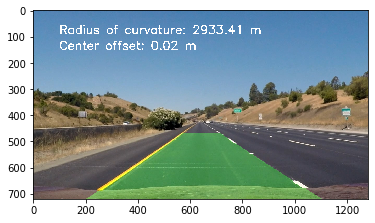

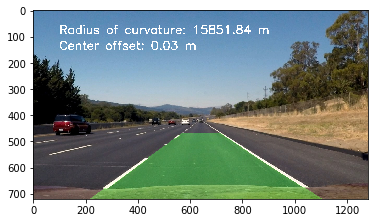

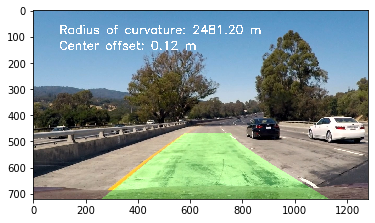

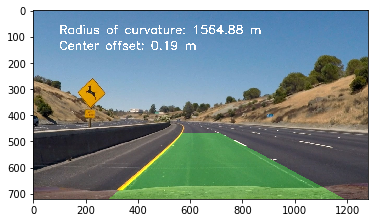

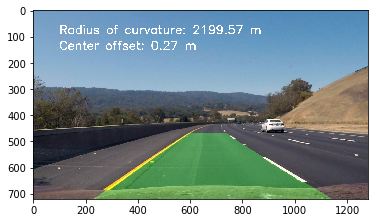

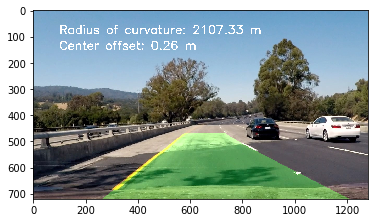

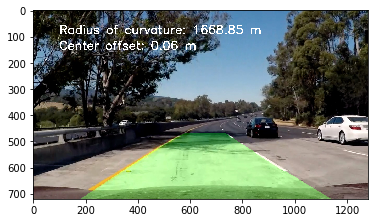

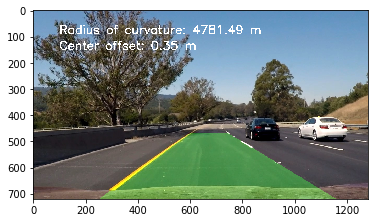

In [20]:
#Computation of camera calibration matrix and distortion coefficients from a set of chessboard images
dist,mtx = CalibrateCamera()
'''
img = mpimg.imread(os.path.join('./test_images','real_test2.jpg'))
result = AdvancePipeline(img)
plt.imshow(result)
plt.show()
'''
for imgName in os.listdir('./test_images'):
    
    img = mpimg.imread(os.path.join('./test_images',imgName))
    
    undistorted_img,edgeBinary,perspective_img,image,result = AdvancePipelineIMG(img)
    
    fig = plt.figure()
    if not os.path.exists("Final_Op_Images"):         
        os.mkdir("Final_Op_Images")
    plt.imshow(result)
    plt.show()
    fig.savefig("Final_Op_Images/"+imgName)   
        

###  Testing  Video : project_video.mp4

In [ ]:
#Computation of camera calibration matrix and distortion coefficients from a set of chessboard images
dist,mtx = CalibrateCamera()

white_output = 'test_videos_output/solidWhiteRight.mp4'
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(AdvancePipeline) 
%time white_clip.write_videofile(white_output, audio=False)


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
#Computation of camera calibration matrix and distortion coefficients from a set of chessboard images
dist,mtx = CalibrateCamera()

white_output = 'test_videos_output/solidWhiteRight.mp4'
video_output = 'challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(AdvancePipeline) 
%time white_clip.write_videofile(white_output, audio=False)